In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import PIL.Image as Image
import os
import math

In [2]:
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torch.utils.tensorboard import SummaryWriter


In [3]:
from model import Unet

In [4]:
class SegDataNp(Dataset):

    def __init__(self,image_paths,img_mean,img_std,transform = None):
        super().__init__()
        self.image_paths = image_paths
        self.transform = transform
        self.img_mean = img_mean
        self.img_std = img_std

    
    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, index):

        file =  np.load(self.image_paths[index])

        image = file[0]
        mask = file[1]

        image = torch.from_numpy(image).to(torch.float32)
        mask = torch.from_numpy(mask).to(torch.long)

        image = torch.unsqueeze(torch.unsqueeze(image,dim=0),dim=0)
        mask = torch.unsqueeze(torch.unsqueeze(mask,dim=0),dim=0)
        
        basic_image_transform = transforms.Compose(transforms=[
            transforms.Resize(size = (128,128)),
            transforms.Normalize(mean = self.img_mean,std = self.img_std),
        ])

        basic_mask_transform = transforms.Compose(transforms=[
            transforms.Resize(size = (128,128)),
        ])

        image = basic_image_transform(image)
        mask = basic_mask_transform(mask)

        if self.transform:

            image = self.transform(image)
            mask = self.transform(mask)
            
        image = image.squeeze()
        mask = mask.squeeze()
        
        sample = {'image':image,'mask':mask}

        return sample

In [5]:
data_dir = '/home/UFAD/s.kapoor/GrainGrowth/skapoor/dl_mis/ACDC/train_files'
total_input_files = []
for file in os.listdir(data_dir):
    if file.endswith('.npy'):
        total_input_files.append(os.path.join(data_dir,file))

In [6]:
from tqdm import tqdm

In [7]:
import gc

In [9]:
def train():

    seed = 13
    torch.manual_seed(seed)
    best_v_loss = 1_000_000

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda:1" if use_cuda else "cpu")
    
    model = Unet(1,4)
    model.to(device)
    epochs = 50
    loss_func = torch.nn.CrossEntropyLoss(weight = torch.tensor([0.0043484 , 0.3454297 , 0.32142933, 0.32879258])) # calculated class imbalance weight
    loss_func.to(device)
#     optimizer = torch.optim.Adam(model.parameters(),lr = 0.001)
    optimizer = torch.optim.SGD(model.parameters(),lr = 0.01,momentum = 0.9, weight_decay = 1e-4)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer = optimizer,factor = 0.8,min_lr=1e-4)
    pth = os.getcwd()
    model_path = os.path.join(pth,'model_q3_unet')
    log_dir = os.path.join(model_path,'runs')
    wts_path = os.path.join(model_path,'weigths')

    if os.path.exists(model_path) == False:
        os.mkdir(model_path)
        
        os.mkdir(log_dir)
        
        os.mkdir(wts_path)
    
    writer = SummaryWriter(log_dir=log_dir)

    #splitting the dataset into traininig and validation set
    train_img,valid_img = train_test_split(total_input_files,test_size=0.2,random_state=seed)
    train_data = SegDataNp(image_paths = train_img,img_mean=90,img_std=101) # calculated mean and std of the bianry images.
    valid_data = SegDataNp(image_paths = valid_img,img_mean=90,img_std=101)
    train_dataloader = DataLoader(train_data,batch_size = 8,shuffle = True,pin_memory = True)
    valid_dataloader = DataLoader(valid_data,batch_size = 8,shuffle = False,pin_memory = True)

    #print("After Model to device : ",torch.cuda.memory_allocated(device)/(1024*1024))
    for e in tqdm(range(epochs)):

        #training the model 
        print('Epoch {0}'.format(e+1))
        epoch_loss = 0.0
        run_loss = 0.0
        model.train(True)

        for i,batch in enumerate(train_dataloader):
            
            image = batch['image'].to(device)
            mask = batch['mask'].to(device)
            
            image = torch.unsqueeze(image,axis = 1)
            mask = torch.unsqueeze(mask,axis = 1)
            
            #print(image.size())
            #print(mask.size())
            
            
    
            #print(batch['image'].shape)
            v_img = transforms.RandomVerticalFlip(p=1)(image)
            h_img = transforms.RandomHorizontalFlip(p=1)(image)
            r_img = transforms.RandomRotation(degrees=(-25,25))(image)
            image_final = torch.cat((image,v_img,h_img,r_img),0)

            #print(image_final.shape)
                    
            v_mask = transforms.RandomVerticalFlip(p=1)(mask)
            h_mask = transforms.RandomHorizontalFlip(p=1)(mask)
            r_mask = transforms.RandomRotation(degrees=(-25,25))(mask)
            mask_final = torch.cat((mask,v_mask,h_mask,r_mask),0)
            mask_final = torch.squeeze(mask_final)
            #print(mask_final.shape)
            
            #break
            
#             image_final.to(device)
#             mask_final.to(device)
            
#             print(image_final.dtype)
#             print(mask_final.dtype)
#             print(device)
            #a = torch.cuda.memory_allocated(device)/(1024*1024)
            optimizer.zero_grad()
            pred = model.forward(image_final)
            #print("after forward pass", torch.cuda.memory_allocated(device)/(1024*1024))
            #b = torch.cuda.memory_allocated(device)/(1024*1024)
            #print("memory consumed by forward_pass",b-a)
            loss = loss_func(pred,mask_final)
            

            run_loss = run_loss + loss.item()
            epoch_loss = epoch_loss + loss.item()
            
            loss.backward()
            #print("memory after backward pass ", torch.cuda.memory_allocated(device)/(1024*1024))
            optimizer.step()
            #print("memory after optimizer ",torch.cuda.memory_allocated(device)/(1024*1024))

            #print('the current loss is {0}'.format(run_loss))
            
            #break
            
#             del mask_final
#             del image_final
#             del pred
#             del v_img
#             del h_img
#             del r_img
#             del v_mask
#             del h_mask
#             del r_mask
#             del mask
#             del image
            
            #print("memory after delete ",torch.cuda.memory_allocated(device)/(1024*1024))
            

            if(i%100 == 99):
                
#                 for obj in gc.get_objects():
#                     try:
#                         if torch.is_tensor(obj) or (hasattr(obj,'data') and torch.is_tensor(obg.data)):
#                             print(type(obj),obj.size())
#                     except:
#                         pass
                

                print("\tBatch Loss for curent for {0} is {1:.5f}".format(i,run_loss/100))
                run_loss = 0.0
                
        #break
        avg_e_loss = epoch_loss/(i+1)
        print('The average loss for the epoch is {0}'.format(avg_e_loss))

        #validating the model
        model.train(False)

        val_loss = 0.0

        for k,batch in enumerate(valid_dataloader):
            final_image = torch.unsqueeze(batch['image'],1).to(device)
            final_mask = batch['mask'].to(device)

            pred = model.forward(final_image)
            loss = loss_func(pred,final_mask)

            val_loss+= loss.item()
            
#             del final_image
#             del final_mask
            #break
        
        

        avg_val_loss = val_loss/(k+1)
        print('The average validation loss for the epoch is {0:.5f}'.format(avg_val_loss))
        writer.add_scalars('Training vs. Validation Loss',
                    { 'Training' : avg_e_loss, 'Validation' : avg_val_loss },
                    e)
        
        if avg_val_loss < best_v_loss:

            best_v_loss = avg_val_loss
            best_wt_path = os.path.join(wts_path,'best_epoch'+str(e))
            

        writer.flush()
        

        #break
        wt_path =  os.path.join(wts_path,'epoch_'+str(e))
        torch.save(model.state_dict(), wt_path)
    torch.save(model.state_dict(), best_wt_path)

In [10]:
train()

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1
	Batch Loss for curent for 99 is 1.04825
The average loss for the epoch is 0.8692965813332203
The average validation loss for the epoch is 0.50054


  2%|▏         | 1/50 [01:22<1:07:33, 82.72s/it]

Epoch 2
	Batch Loss for curent for 99 is 0.39408
The average loss for the epoch is 0.3499760123759664
The average validation loss for the epoch is 0.23893


  4%|▍         | 2/50 [02:37<1:02:19, 77.90s/it]

Epoch 3
	Batch Loss for curent for 99 is 0.27339
The average loss for the epoch is 0.2623665232152839
The average validation loss for the epoch is 0.18517


  6%|▌         | 3/50 [03:56<1:01:28, 78.47s/it]

Epoch 4
	Batch Loss for curent for 99 is 0.24243
The average loss for the epoch is 0.24229498254379053
The average validation loss for the epoch is 0.18106


  8%|▊         | 4/50 [05:14<1:00:11, 78.51s/it]

Epoch 5
	Batch Loss for curent for 99 is 0.23943
The average loss for the epoch is 0.23542679284567608
The average validation loss for the epoch is 0.17846


 10%|█         | 5/50 [06:30<58:09, 77.54s/it]  

Epoch 6
	Batch Loss for curent for 99 is 0.22303
The average loss for the epoch is 0.2174159073080692
The average validation loss for the epoch is 0.17157


 12%|█▏        | 6/50 [07:44<55:53, 76.22s/it]

Epoch 7
	Batch Loss for curent for 99 is 0.21432
The average loss for the epoch is 0.20864287248924765
The average validation loss for the epoch is 0.16462


 14%|█▍        | 7/50 [08:59<54:16, 75.73s/it]

Epoch 8
	Batch Loss for curent for 99 is 0.19432
The average loss for the epoch is 0.19563293035741877
The average validation loss for the epoch is 0.14593


 16%|█▌        | 8/50 [10:15<53:05, 75.86s/it]

Epoch 9
	Batch Loss for curent for 99 is 0.19393
The average loss for the epoch is 0.19261999911974861
The average validation loss for the epoch is 0.15146


 18%|█▊        | 9/50 [11:31<51:52, 75.92s/it]

Epoch 10
	Batch Loss for curent for 99 is 0.18893
The average loss for the epoch is 0.1852908651320098
The average validation loss for the epoch is 0.14338


 20%|██        | 10/50 [12:48<50:47, 76.20s/it]

Epoch 11
	Batch Loss for curent for 99 is 0.17740
The average loss for the epoch is 0.17924849529072875
The average validation loss for the epoch is 0.17808


 22%|██▏       | 11/50 [14:03<49:15, 75.79s/it]

Epoch 12
	Batch Loss for curent for 99 is 0.17256
The average loss for the epoch is 0.17418889046027397
The average validation loss for the epoch is 0.13361


 24%|██▍       | 12/50 [15:18<48:01, 75.83s/it]

Epoch 13
	Batch Loss for curent for 99 is 0.17108
The average loss for the epoch is 0.16927040290302006
The average validation loss for the epoch is 0.14485


 26%|██▌       | 13/50 [16:33<46:33, 75.49s/it]

Epoch 14
	Batch Loss for curent for 99 is 0.20551
The average loss for the epoch is 0.1944253922913087
The average validation loss for the epoch is 0.12707


 28%|██▊       | 14/50 [17:49<45:23, 75.66s/it]

Epoch 15
	Batch Loss for curent for 99 is 0.17152
The average loss for the epoch is 0.1722160724835246
The average validation loss for the epoch is 0.13364


 30%|███       | 15/50 [19:05<44:05, 75.59s/it]

Epoch 16
	Batch Loss for curent for 99 is 0.16491
The average loss for the epoch is 0.16840916833016262
The average validation loss for the epoch is 0.15651


 32%|███▏      | 16/50 [20:20<42:46, 75.48s/it]

Epoch 17
	Batch Loss for curent for 99 is 0.15852
The average loss for the epoch is 0.15711854565986164
The average validation loss for the epoch is 0.12109


 34%|███▍      | 17/50 [21:40<42:12, 76.73s/it]

Epoch 18
	Batch Loss for curent for 99 is 0.15366
The average loss for the epoch is 0.1538480065802005
The average validation loss for the epoch is 0.12472


 36%|███▌      | 18/50 [22:55<40:42, 76.33s/it]

Epoch 19
	Batch Loss for curent for 99 is 0.14877
The average loss for the epoch is 0.15319940833989237
The average validation loss for the epoch is 0.14424


 38%|███▊      | 19/50 [24:11<39:26, 76.33s/it]

Epoch 20
	Batch Loss for curent for 99 is 0.14303
The average loss for the epoch is 0.14815359383197355
The average validation loss for the epoch is 0.11756


 40%|████      | 20/50 [25:27<38:07, 76.24s/it]

Epoch 21
	Batch Loss for curent for 99 is 0.14754
The average loss for the epoch is 0.15021556163333474
The average validation loss for the epoch is 0.13660


 42%|████▏     | 21/50 [26:42<36:39, 75.86s/it]

Epoch 22
	Batch Loss for curent for 99 is 0.14390
The average loss for the epoch is 0.14456710640672613
The average validation loss for the epoch is 0.12201


 44%|████▍     | 22/50 [27:57<35:16, 75.58s/it]

Epoch 23
	Batch Loss for curent for 99 is 0.13948
The average loss for the epoch is 0.1402467284839191
The average validation loss for the epoch is 0.13260


 46%|████▌     | 23/50 [29:13<34:02, 75.64s/it]

Epoch 24
	Batch Loss for curent for 99 is 0.14247
The average loss for the epoch is 0.14152484418365968
The average validation loss for the epoch is 0.13655


 48%|████▊     | 24/50 [30:29<32:53, 75.90s/it]

Epoch 25
	Batch Loss for curent for 99 is 0.13798
The average loss for the epoch is 0.1389207520488045
The average validation loss for the epoch is 0.12137


 50%|█████     | 25/50 [31:47<31:50, 76.44s/it]

Epoch 26
	Batch Loss for curent for 99 is 0.13903
The average loss for the epoch is 0.13779912904607064
The average validation loss for the epoch is 0.14687


 52%|█████▏    | 26/50 [33:02<30:22, 75.93s/it]

Epoch 27
	Batch Loss for curent for 99 is 0.14657
The average loss for the epoch is 0.14311560235566495
The average validation loss for the epoch is 0.13506


 54%|█████▍    | 27/50 [34:17<29:02, 75.75s/it]

Epoch 28
	Batch Loss for curent for 99 is 0.13131
The average loss for the epoch is 0.13428769299653187
The average validation loss for the epoch is 0.12654


 56%|█████▌    | 28/50 [35:32<27:40, 75.48s/it]

Epoch 29
	Batch Loss for curent for 99 is 0.13279
The average loss for the epoch is 0.13372582505354708
The average validation loss for the epoch is 0.13097


 58%|█████▊    | 29/50 [36:47<26:23, 75.39s/it]

Epoch 30
	Batch Loss for curent for 99 is 0.12711
The average loss for the epoch is 0.12608917416390325
The average validation loss for the epoch is 0.12682


 60%|██████    | 30/50 [38:03<25:07, 75.36s/it]

Epoch 31
	Batch Loss for curent for 99 is 0.12782
The average loss for the epoch is 0.127701094286292
The average validation loss for the epoch is 0.12595


 62%|██████▏   | 31/50 [39:18<23:49, 75.26s/it]

Epoch 32
	Batch Loss for curent for 99 is 0.12305
The average loss for the epoch is 0.12497028392490916
The average validation loss for the epoch is 0.13473


 64%|██████▍   | 32/50 [40:36<22:51, 76.18s/it]

Epoch 33
	Batch Loss for curent for 99 is 0.12956
The average loss for the epoch is 0.13031437891628106
The average validation loss for the epoch is 0.12408


 66%|██████▌   | 33/50 [41:51<21:30, 75.94s/it]

Epoch 34
	Batch Loss for curent for 99 is 0.12223
The average loss for the epoch is 0.12425690390052596
The average validation loss for the epoch is 0.12764


 68%|██████▊   | 34/50 [43:07<20:12, 75.79s/it]

Epoch 35
	Batch Loss for curent for 99 is 0.12059
The average loss for the epoch is 0.12099670829417193
The average validation loss for the epoch is 0.14278


 70%|███████   | 35/50 [44:21<18:50, 75.37s/it]

Epoch 36
	Batch Loss for curent for 99 is 0.11963
The average loss for the epoch is 0.12040099439196561
The average validation loss for the epoch is 0.13620


 72%|███████▏  | 36/50 [45:37<17:38, 75.63s/it]

Epoch 37
	Batch Loss for curent for 99 is 0.12485
The average loss for the epoch is 0.1237278549458968
The average validation loss for the epoch is 0.14059


 74%|███████▍  | 37/50 [46:54<16:26, 75.86s/it]

Epoch 38
	Batch Loss for curent for 99 is 0.12059
The average loss for the epoch is 0.12134721130132675
The average validation loss for the epoch is 0.12853


 76%|███████▌  | 38/50 [48:10<15:10, 75.91s/it]

Epoch 39
	Batch Loss for curent for 99 is 0.12183
The average loss for the epoch is 0.11927053812130584
The average validation loss for the epoch is 0.13047


 78%|███████▊  | 39/50 [49:25<13:51, 75.58s/it]

Epoch 40
	Batch Loss for curent for 99 is 0.11775
The average loss for the epoch is 0.1157727131122694
The average validation loss for the epoch is 0.13438


 80%|████████  | 40/50 [50:34<12:18, 73.80s/it]

Epoch 41
	Batch Loss for curent for 99 is 0.11717
The average loss for the epoch is 0.1145379366596956
The average validation loss for the epoch is 0.13430


 82%|████████▏ | 41/50 [51:45<10:54, 72.76s/it]

Epoch 42
	Batch Loss for curent for 99 is 0.11967
The average loss for the epoch is 0.11735429349526061
The average validation loss for the epoch is 0.13797


 84%|████████▍ | 42/50 [52:54<09:33, 71.71s/it]

Epoch 43
	Batch Loss for curent for 99 is 0.11853
The average loss for the epoch is 0.11735107219188001
The average validation loss for the epoch is 0.13247


 86%|████████▌ | 43/50 [54:04<08:18, 71.15s/it]

Epoch 44
	Batch Loss for curent for 99 is 0.11178
The average loss for the epoch is 0.11272203684321248
The average validation loss for the epoch is 0.14692


 88%|████████▊ | 44/50 [55:13<07:03, 70.64s/it]

Epoch 45
	Batch Loss for curent for 99 is 0.11423
The average loss for the epoch is 0.11119255805826936
The average validation loss for the epoch is 0.15447


 90%|█████████ | 45/50 [56:23<05:51, 70.29s/it]

Epoch 46
	Batch Loss for curent for 99 is 0.10980
The average loss for the epoch is 0.10979910233882086
The average validation loss for the epoch is 0.14360


 92%|█████████▏| 46/50 [57:33<04:41, 70.32s/it]

Epoch 47
	Batch Loss for curent for 99 is 0.10173
The average loss for the epoch is 0.10670923976061857
The average validation loss for the epoch is 0.15961


 94%|█████████▍| 47/50 [58:42<03:29, 69.98s/it]

Epoch 48
	Batch Loss for curent for 99 is 0.10982
The average loss for the epoch is 0.11175535217473644
The average validation loss for the epoch is 0.13746


 96%|█████████▌| 48/50 [59:52<02:19, 69.84s/it]

Epoch 49
	Batch Loss for curent for 99 is 0.10777
The average loss for the epoch is 0.10882660766078539
The average validation loss for the epoch is 0.15971


 98%|█████████▊| 49/50 [1:01:01<01:09, 69.69s/it]

Epoch 50
	Batch Loss for curent for 99 is 0.10438
The average loss for the epoch is 0.10428632803612355
The average validation loss for the epoch is 0.16381


100%|██████████| 50/50 [1:02:11<00:00, 74.62s/it]


In [ ]:
torch.cuda.empty_cache()

In [11]:
def diceScoreMulti(inputs,targets,num_class = 4):
    epsilon = 1e-6
    #print('pred tensor size ',inputs.size())
#     inputs = torch.nn.Softmax(dim = 1)(inputs)
#     #print('pred tensor size after softmax',inputs.size())
#     _,y_pred_idx = torch.max(inputs,dim = 1)
    dice_scores = []
    for class_idx in range(num_class):
        y_true_class = (targets == class_idx).float()
        y_pred_class = (y_pred_idx == class_idx).float()

        intersection = torch.sum(y_true_class * y_pred_class, dim = (1,2))
        total = torch.sum(y_true_class,dim = (1,2)) + torch.sum(y_pred_class,dim= (1,2))
        dice = (2. * intersection + epsilon)/(total+epsilon)
        dice_scores.append(torch.mean(dice).item()) # getting mean across batches of particular class
    average_dice = torch.mean(torch.tensor(dice_scores)) # getting mean across classes
    return average_dice

In [12]:
test_dir = '/home/UFAD/s.kapoor/GrainGrowth/skapoor/dl_mis/ACDC/test_files'
total_test_files = []
for file in os.listdir(test_dir):
    if file.endswith('.npy'):
        total_test_files.append(os.path.join(test_dir,file))

In [15]:
# visualize the mask outputs
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:1" if use_cuda else "cpu")

#     train_data = SegData(image_paths = train_img,mask_paths=train_mask,img_mean=[129.908, 129.908, 129.908],img_std=[64.484, 64.484, 64.484])
#valid_data = SegData(image_paths = valid_img,mask_paths=valid_mask,img_mean=[129.908, 129.908, 129.908],img_std=[64.484, 64.484, 64.484])
test_data = SegDataNp(image_paths = total_test_files,img_mean=90,img_std=101)
model_vis = Unet(1,4)
model_vis_path = '/home/UFAD/s.kapoor/GrainGrowth/skapoor/dl_mis/COVID-19_Radiography_Dataset/UNET/model_q3_unet/weigths/best_epoch19'
model_vis.load_state_dict(torch.load(model_vis_path))
model_vis.to(device)
model_vis.eval()
dice_scores = []

test_dataloader = DataLoader(test_data,batch_size = 1,shuffle = True,pin_memory = True)
for k,batch in enumerate(test_dataloader):
    final_image = torch.unsqueeze(batch['image'],1).to(device)
    final_mask = batch['mask'].to(device)

    pred = model_vis.forward(final_image)
    pred = torch.nn.Softmax(dim = 1)(pred)
    #print('pred tensor size after softmax',inputs.size())
    _,y_pred_idx = torch.max(pred,dim = 1)
    dice_score = diceScoreMulti(y_pred_idx,final_mask)
    dice_scores.append(dice_score.item())
    #print('the dice score is {0}'.format(dice_score.item()))

print('The average dice score is {0}'.format(np.mean(np.array(dice_scores))))

The average dice score is 0.8370702806375505


Text(0.5, 1.0, 'pred mask')

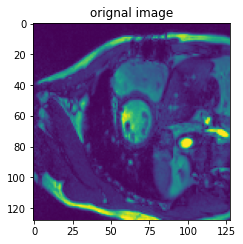

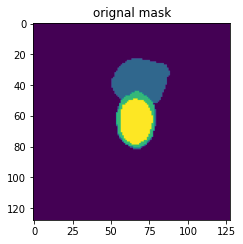

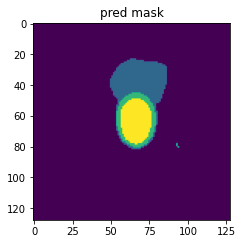

In [16]:
final_image_transpose = torch.squeeze(final_image).cpu().detach().numpy()
                                
final_mask_transpose = torch.squeeze(final_mask).cpu().detach().numpy()

pred_image_transpose = torch.squeeze(y_pred_idx).cpu().detach().numpy()


                                
                                
plt.figure(figsize = (12,4))
plt.subplot(1,3,1)
plt.imshow(final_image_transpose)
plt.title('orignal image')

plt.figure(figsize = (12,4))
plt.subplot(1,3,2)
plt.imshow(final_mask_transpose)
plt.title('orignal mask')

plt.figure(figsize = (12,4))
plt.subplot(1,3,3)
plt.imshow(pred_image_transpose)
plt.title('pred mask')

In [ ]:
total_mean

In [ ]:
total_std

In [ ]:
import pytorch_model_summary as pms

In [ ]:
model = Unet(3,1)

In [ ]:
print(pms.summary(model, torch.zeros((32, 3, 256, 256)), show_input=True, show_hierarchical=True))